In [1]:
import re
from typing import List, Optional, Tuple
import numpy as np

# ---------- Parse "(re,im)" tuples; one "Taps starting:" block = one OFDM symbol ----------
_PAIR = re.compile(
    r"\(\s*([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*,\s*"
    r"([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*\)"
)

def read_symbol_csi(
    path: str,
    section_headers=("Taps starting", "CSI starting"),
) -> List[np.ndarray]:
    frames: List[np.ndarray] = []
    cur: List[Tuple[float,float]] = []

    def flush():
        nonlocal cur
        if cur:
            frames.append(np.array([a + 1j*b for a,b in cur], dtype=np.complex64))
            cur = []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if any(h.lower() in s.lower() for h in section_headers):
                flush()
                continue
            m = _PAIR.search(s)
            if m:
                cur.append((float(m.group(1)), float(m.group(2))))
    flush()
    return frames  # list of complex64 arrays, one per OFDM symbol (length should be 64)

# ---------- Helpers ----------
def ofdm_Tsym(fs: float, nfft: int, cp_ratio: float) -> float:
    """OFDM symbol duration (incl. CP) in seconds."""
    Tu = nfft / fs
    return Tu * (1.0 + cp_ratio)

def remove_cpe(H: np.ndarray, used_bins: Optional[np.ndarray] = None) -> np.ndarray:
    if used_bins is None:
        used_bins = np.ones_like(H, dtype=bool)
    ph = np.angle(np.mean(H[used_bins]))
    return H * np.exp(-1j * ph)

# ---------- Resample symbol stream to exactly 1 kHz ----------
def resample_csi_to_1khz(
    symbols: List[np.ndarray],
    fs: float = 5e6,
    nfft: int = 64,
    cp_ratio: float = 1/8,
    do_cpe: bool = True,
    used_bins: Optional[np.ndarray] = None,
    amp_norm: Optional[str] = None,   # 'rms' | 'mean' | None
    fill: str = "zoh"                 # 'zoh' (hold) | 'nan'
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Input:
      symbols: list of complex CSI vectors (one per OFDM symbol).
    Output:
      times: shape [N_out], seconds
      csi_1k: shape [N_out, nfft] complex64, 1 kHz (Δt = 1 ms) rate
    """
    if not symbols:
        return np.zeros((0,), dtype=float), np.zeros((0,0), dtype=np.complex64)
    N = len(symbols[0])
    assert all(len(s) == N for s in symbols), "All symbols must have same length"
    Ts = ofdm_Tsym(fs, nfft, cp_ratio)             # ~14.4 us at 5 MHz, 64-pt, CP=1/8
    t_sym = np.arange(len(symbols), dtype=np.float64) * Ts  # assume contiguous symbols
    t0, t_end = t_sym[0], t_sym[-1] + Ts
    dt = 1e-3                                      # 1 ms
    times = np.arange(t0, t_end, dt, dtype=np.float64)
    out = np.empty((len(times), N), dtype=np.complex64)

    last = np.zeros(N, dtype=np.complex64)
    def _norm(v: np.ndarray) -> np.ndarray:
        if amp_norm is None: return v
        mask = used_bins if used_bins is not None else np.ones(N, dtype=bool)
        if amp_norm == "rms":
            s = np.sqrt(np.mean(np.abs(v[mask])**2))
        elif amp_norm == "mean":
            s = np.mean(np.abs(v[mask]))
        else:
            raise ValueError("amp_norm must be 'rms', 'mean', or None")
        return v if s == 0 else v / s

    # Preprocess each symbol once (CPE + optional amp norm)
    proc = []
    for H in symbols:
        x = H.astype(np.complex64, copy=True)
        if do_cpe:
            x = remove_cpe(x, used_bins=used_bins)
        x = _norm(x)
        proc.append(x)
    proc = np.stack(proc, axis=0)  # [Nsym, N]

    # Windowed average into 1 ms bins
    idx_start = 0
    for i, t in enumerate(times):
        t1 = t
        t2 = t + dt
        # symbols whose start time falls in [t1, t2)
        while idx_start < len(t_sym) and t_sym[idx_start] < t1:
            idx_start += 1
        idx_end = idx_start
        while idx_end < len(t_sym) and t_sym[idx_end] < t2:
            idx_end += 1

        if idx_end > idx_start:
            avg = proc[idx_start:idx_end].mean(axis=0)
            out[i] = avg
            last = avg
        else:
            if fill == "zoh":
                out[i] = last
            else:
                out[i] = np.nan + 1j*np.nan

    return times, out


## build a pipeline to seperate each digit

In [14]:
# for date_num in ['A', 'B', 'C', 'D', 'E']:
#     date = f'9_29_{date_num}'
# date = '9_29_E'
date = '10_28'
path = f"taps_10_28_num_0_4.txt"   # your captured file
syms = read_symbol_csi(path)   # list of 64-bin complex vectors, one per OFDM symbol
# If you have DC/guards, you can exclude them from CPE/normalization:
used_mask = None


# used_mask = np.ones(64, dtype=bool); used_mask[32] = False  # example: drop DC bin

t, H_1k = resample_csi_to_1khz(
syms,
fs=1e6, nfft=64, cp_ratio=1/4,
do_cpe=True,
used_bins=used_mask,
amp_norm=None,     # or 'rms' for scale invariance
fill="zoh"
)
print("1 kHz CSI shape:", H_1k.shape)   # (N_out, 64)
# np.save(f"csi_1khz_{date}_num_0.npy", H_1k)      ##  averaging process
# # # Optional exports for ML:
# np.savetxt(f"csi_1khz_mag_{date}_num_0.csv", np.abs(H_1k), delimiter=",")
np.savetxt(f"csi_1khz_phase_{date}_num_0_4.csv", np.angle(H_1k), delimiter=",")
np.savetxt(f"csi_mag_{date}_num_0_4.csv", np.abs(syms), delimiter=",")
# H_1k shape: (T, Nsc) complex
T, N = H_1k.shape
keep_idx = np.arange(N)[6:N-5]      # drop first 6, last 5
H_1k_trim = H_1k[:, keep_idx]       # (T, N-11)
np.savetxt(f"csi_1khz_mag_{date}_num_0_4.csv", np.abs(H_1k_trim), delimiter=",")


# path = f"taps_{date}_num_34567.txt"   # your captured file
syms = read_symbol_csi(path)   # list of 64-bin complex vectors, one per OFDM symbol
# If you have DC/guards, you can exclude them from CPE/normalization:
used_mask = None



1 kHz CSI shape: (589, 64)


## wavelet

In [15]:
import numpy as np
import pywt  # pip install PyWavelets

def _minimax_thresh(x):
    """
    Donoho–Johnstone minimax threshold:
    T = sigma * (0.3936 + 0.1829 * log2(n)), sigma from MAD of finest details.
    """
    n = x.size
    if n <= 1:
        return 0.0
    return (0.3936 + 0.1829 * np.log2(n))

def _wavelet_denoise_1d(x, wavelet="db4", level=4, thr_mode="soft"):
    """
    DWT -> threshold detail coeffs -> IDWT
    Matches the paper: Daubechies D4, 4 levels, adaptive minimax threshold. :contentReference[oaicite:1]{index=1}
    """
    coeffs = pywt.wavedec(x, wavelet=wavelet, level=level, mode="symmetric")
    cA, cD_list = coeffs[0], coeffs[1:]

    # noise sigma from level-1 details (finest scale)
    cD1 = cD_list[-1]  # last item is level-1 in PyWavelets order
    sigma = np.median(np.abs(cD1)) / 0.6745 if cD1.size else 0.0
    T = sigma * _minimax_thresh(x)

    # threshold all detail coeffs
    cD_thr = [pywt.threshold(cD, value=T, mode=thr_mode) for cD in cD_list]

    # reconstruct
    coeffs_thr = [cA] + cD_thr
    y = pywt.waverec(coeffs_thr, wavelet=wavelet, mode="symmetric")
    # match original length
    return y[: len(x)]

def denoise_csi(H, wavelet="db4", level=4, thr_mode="soft", apply_to="complex"):
    """
    Wavelet denoise CSI matrix H (T, S).
      apply_to: "complex" (default) -> denoise real & imag separately and recombine,
                 "magnitude"       -> denoise |H| and keep original phase,
                 "real"            -> denoise real only (imag unchanged)
    Returns H_denoised with same shape/dtype as H.
    """
    H = np.asarray(H)
    T, S = H.shape
    out = np.empty_like(H, dtype=np.complex128)

    if apply_to == "complex":
        for k in range(S):
            xr = _wavelet_denoise_1d(np.real(H[:, k]), wavelet, level, thr_mode)
            xi = _wavelet_denoise_1d(np.imag(H[:, k]), wavelet, level, thr_mode)
            out[:, k] = xr + 1j * xi

    elif apply_to == "magnitude":
        mag = np.abs(H); ph = np.angle(H)
        for k in range(S):
            mdk = _wavelet_denoise_1d(mag[:, k], wavelet, level, thr_mode)
            out[:, k] = mdk * np.exp(1j * ph[:, k])

    elif apply_to == "real":
        out[:] = H
        for k in range(S):
            xr = _wavelet_denoise_1d(np.real(H[:, k]), wavelet, level, thr_mode)
            out[:, k] = xr + 1j * np.imag(H[:, k])
    else:
        raise ValueError("apply_to must be 'complex', 'magnitude', or 'real'.")

    return out

# ---- Example usage for your resampled H_1k ----

# H_1k shape: (T, S) complex; fs=1 kHz slow-time
H_1k_trim_denoised = denoise_csi(H_1k_trim, wavelet="db4", level=4, thr_mode="soft", apply_to="complex")
np.savetxt(f"csi_1khz_mag_denoised_{date}_num_0_4.csv", np.abs(H_1k_trim_denoised), delimiter=",")

## bandpass filter

In [4]:
import numpy as np
from scipy.signal import butter, sosfiltfilt

def bandpass_csi(H, fs=1000.0, f_lo=5.0, f_hi=80.0, order=4, axis=0):
    """
    Zero-phase bandpass for complex CSI using SOS Butterworth + filtfilt.
    H: array (..., T, ...) where `axis` is the time axis
    """
    nyq = fs * 0.5
    if not (0 < f_lo < f_hi < nyq):
        raise ValueError(f"Cutoffs must satisfy 0 < {f_lo} < {f_hi} < {nyq} Hz")
    sos = butter(order, [f_lo/nyq, f_hi/nyq], btype='band', output='sos')
    return sosfiltfilt(sos, H, axis=axis)

# --- apply to your data ---
# Decide which dimension is time by matching t.size
time_axis = 0 if H_1k_trim.shape[0] == t.size else 1
H_1k_bp = bandpass_csi(H_1k_trim, fs=1000.0, f_lo=0.1, f_hi=100.0, order=4, axis=time_axis)
np.savetxt(f"csi_filter_mag_{date}_num_0.csv", np.abs(H_1k_bp), delimiter=",")

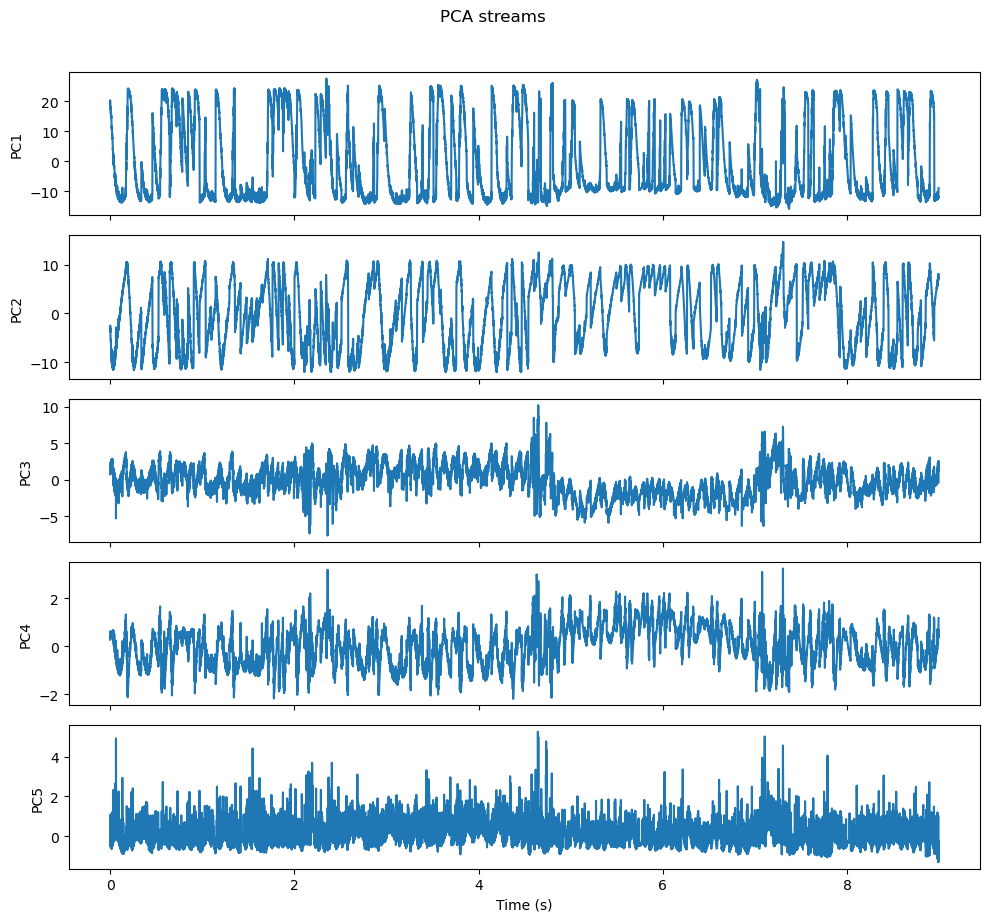

In [240]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, stft
from sklearn.decomposition import PCA  # optional, only if you use PCA
# H_1k_trim_a = H_1k_trim[300:, :]
H_1k_trim_a = H_1k_trim
# Stack real & imag as features or use magnitude—here we use complex-as-2ch
X = np.c_[np.real(H_1k_trim_a), np.imag(H_1k_trim_a)]  # shape (T, 2S)
n_pca = 5
pca = PCA(n_components=n_pca)
Z = pca.fit_transform(X)                 # (T, n_pca)
Z.shape

fs = 1000
T, K = Z.shape
t = np.arange(T) / fs

fig, axs = plt.subplots(K, 1, figsize=(10, 1.8*K), sharex=True)
if K == 1:
    axs = [axs]
for k in range(K):
    axs[k].plot(t, Z[:, k])
    axs[k].set_ylabel(f"PC{k+1}")
axs[-1].set_xlabel("Time (s)")
fig.suptitle("PCA streams ", y=1.02)
plt.tight_layout()
plt.show()

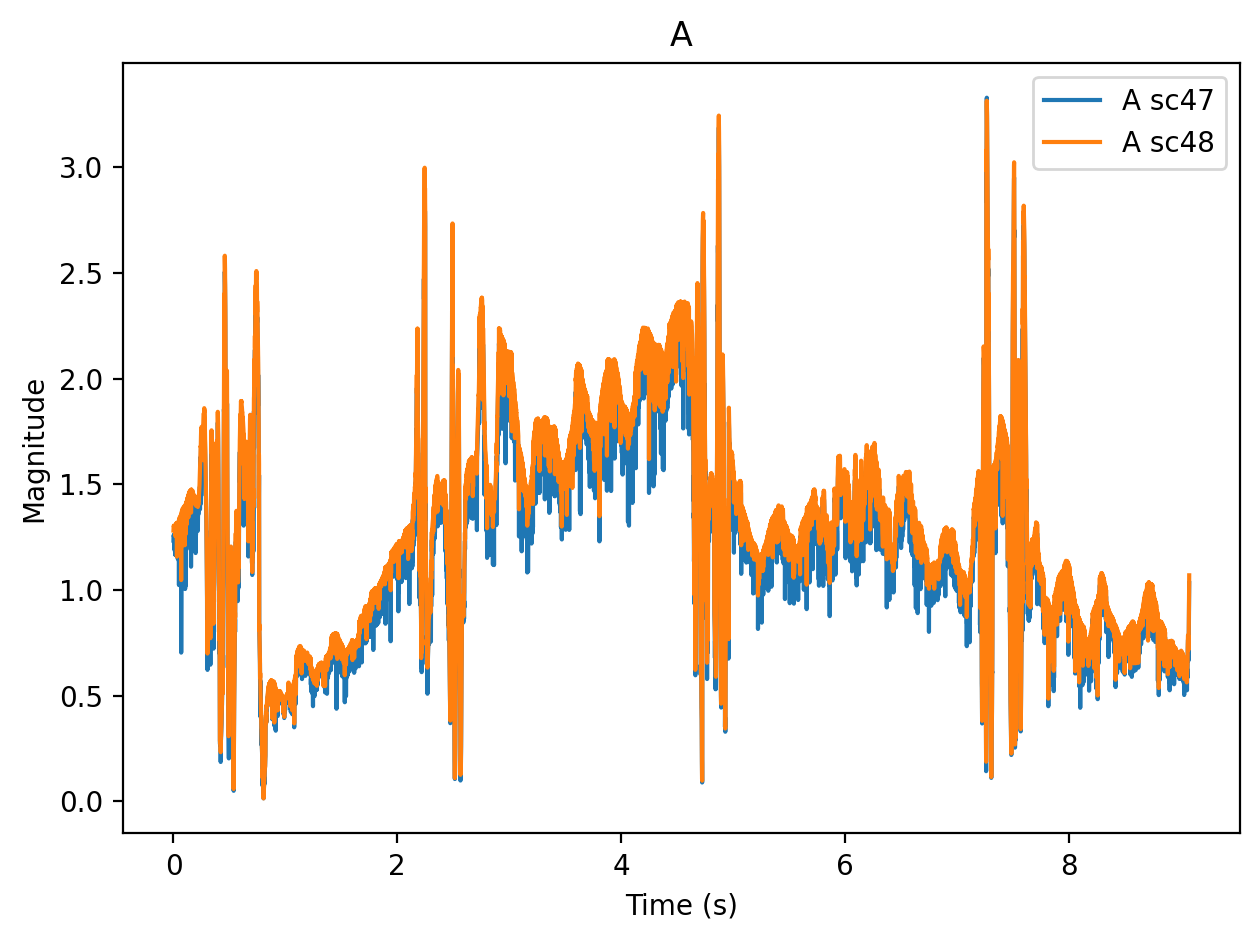

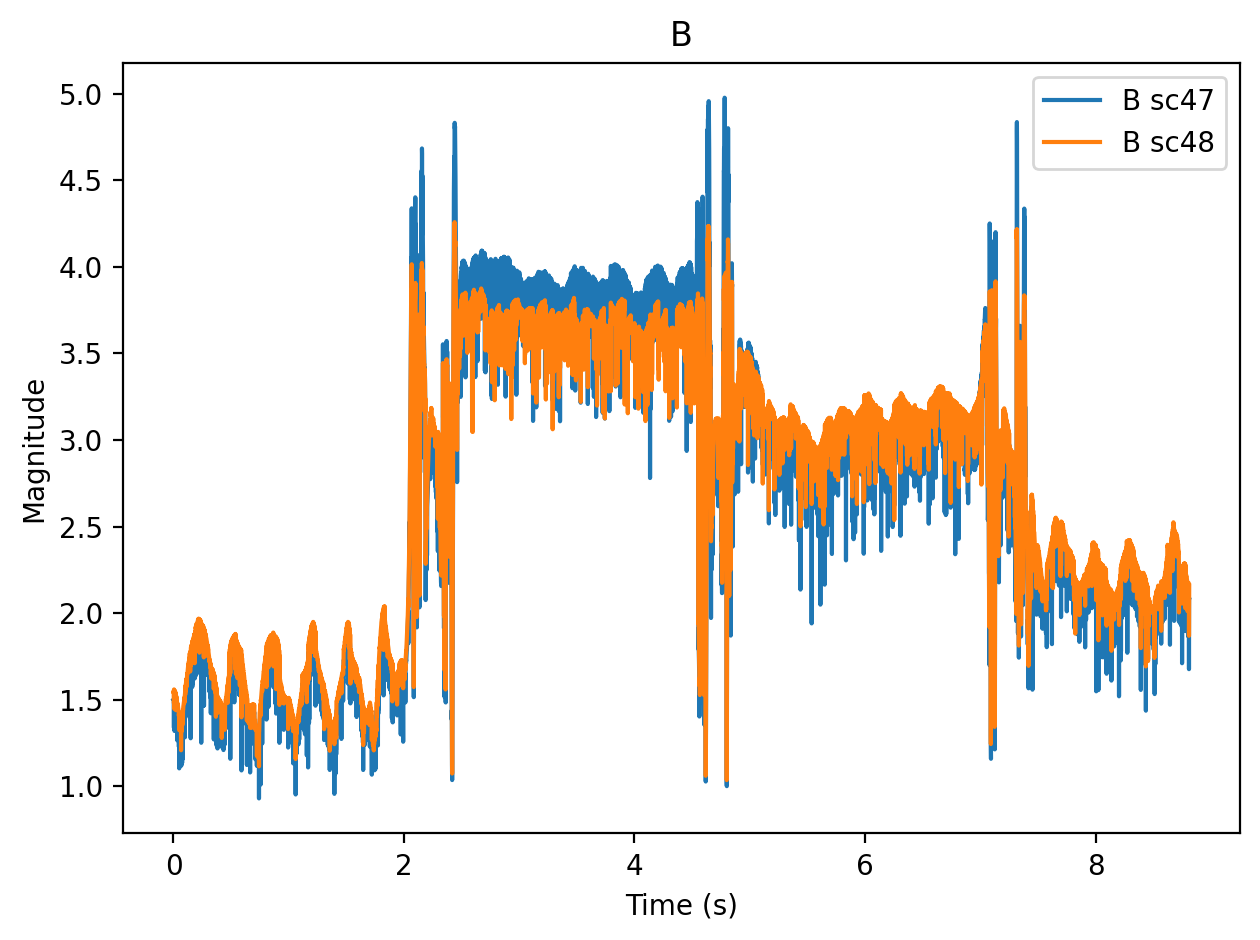

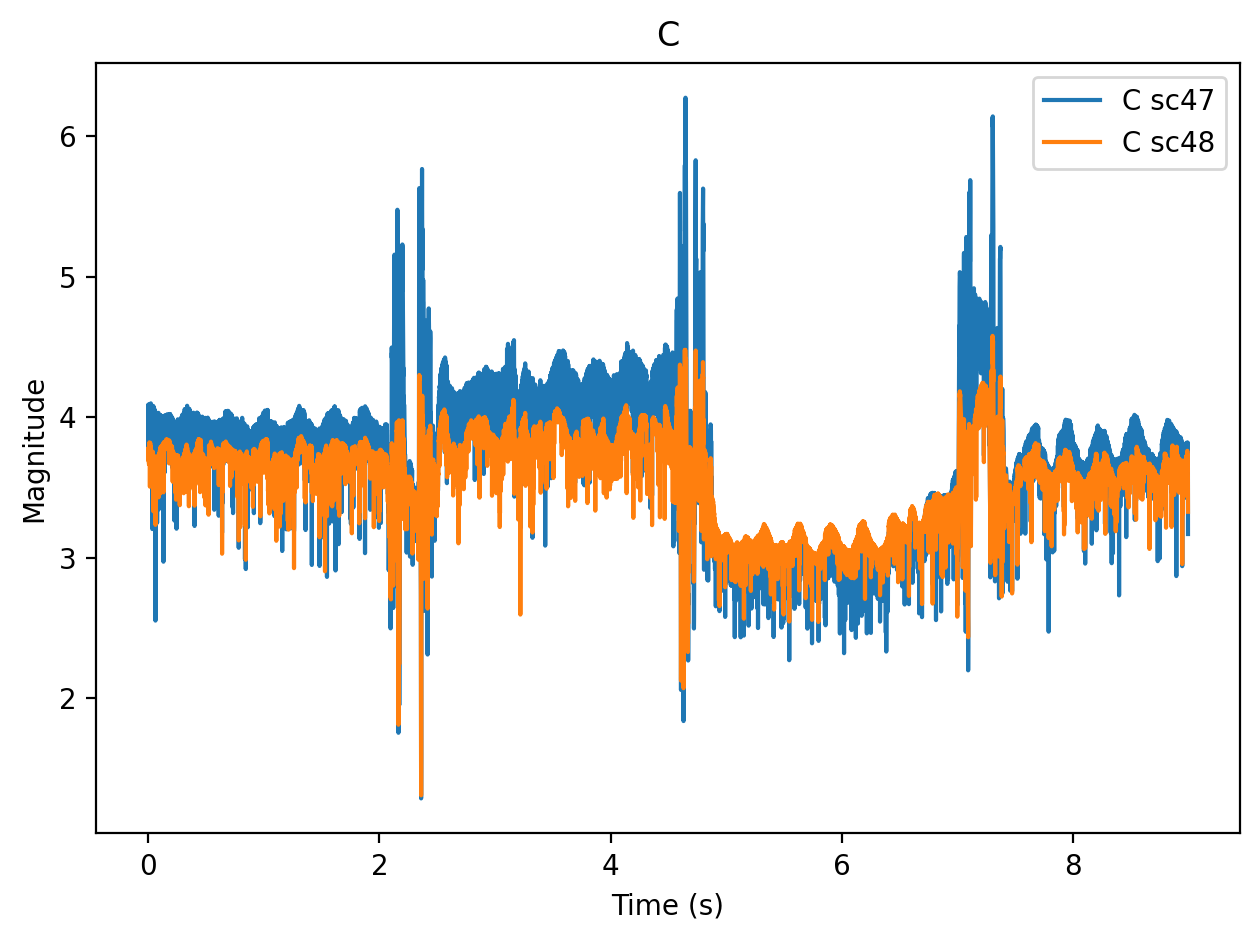

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

files = {
    "A": "csi_1khz_mag_9_23_num_0.csv",
    "B": "csi_1khz_mag_9_23_B_num_0.csv",
    "C": "csi_1khz_mag_denoised_9_23_B_num_0.csv",
}
fs = 1000.0

def get_cols(df, targets=("sc36","sc37"), idxs=(47,48)):
    if all(c in df.columns for c in targets):
        return df[list(targets)]
    for tcol in ("t","time","Time","timestamp"):
        if tcol in df.columns: df = df.drop(columns=[tcol])
    return df.iloc[:, list(idxs)]

def load_two_cols(path):
    try: df = pd.read_csv(path)
    except Exception: df = pd.read_csv(path, header=None)
    return get_cols(df)

DA = load_two_cols(files["A"])
DB = load_two_cols(files["B"])
DC = load_two_cols(files["C"])



t = np.arange(len(DA)) * fs / 1e6
import matplotlib.pyplot as plt

# Figure A
plt.figure(dpi=200)
plt.plot(t, DA.iloc[:,0], label="A sc47")
plt.plot(t, DA.iloc[:,1], label="A sc48")
plt.title("A")
plt.xlabel("Time (s)"); plt.ylabel("Magnitude")
plt.legend(); plt.tight_layout(); plt.show()

# Figure B
tB = np.arange(len(DB)) / fs
plt.figure(dpi=200)
plt.plot(tB, DB.iloc[:,0], label="B sc47")
plt.plot(tB, DB.iloc[:,1], label="B sc48")
plt.title("B")
plt.xlabel("Time (s)"); plt.ylabel("Magnitude")
plt.legend(); plt.tight_layout(); plt.show()

# Figure C
tC = np.arange(len(DC)) / fs
plt.figure(dpi=200)
plt.plot(tC, DC.iloc[:,0], label="C sc47")
plt.plot(tC, DC.iloc[:,1], label="C sc48")
plt.title("C")
plt.xlabel("Time (s)"); plt.ylabel("Magnitude")
plt.legend(); plt.tight_layout(); plt.show()


In [3]:
## now write code to store DA, DB, DC,
# then do norm for each one,
import numpy as np
import pandas as pd

# --- save raw ---
DA.to_csv("A_raw.csv", index=False)
DB.to_csv("B_raw.csv", index=False)
DC.to_csv("C_raw.csv", index=False)

# --- z-score normalize each column (per file) ---
def zscore(df: pd.DataFrame) -> pd.DataFrame:
    mu = df.mean(axis=0)
    sigma = df.std(axis=0, ddof=0)
    sigma_safe = sigma.replace(0, 1.0)  # avoid divide-by-zero
    return (df - mu) / sigma_safe
def minmax01(df):
    mn = df.min(axis=0); mx = df.max(axis=0)
    span = (mx - mn).replace(0, 1.0)
    return (df - mn) / span

DA_norm = minmax01(DA)
DB_norm = minmax01(DB)
DC_norm = minmax01(DC)

# --- save normalized ---
DA_norm.to_csv("A_norm.csv", index=False)
DB_norm.to_csv("B_norm.csv", index=False)
DC_norm.to_csv("C_norm.csv", index=False)


## pattern select

selected: 4 segments: [(7149, 7728), (330, 878), (4594, 5029), (2146, 2723)]


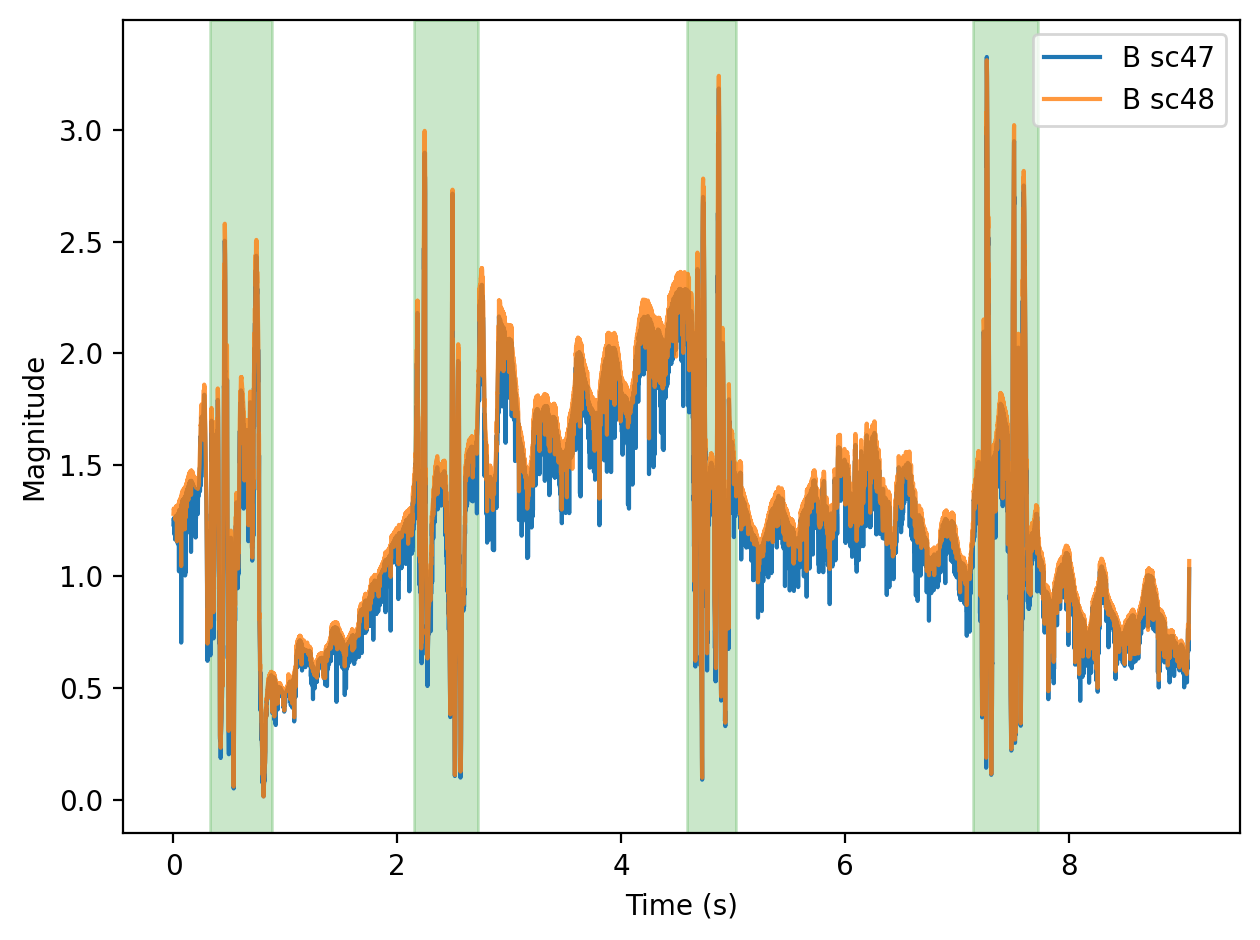

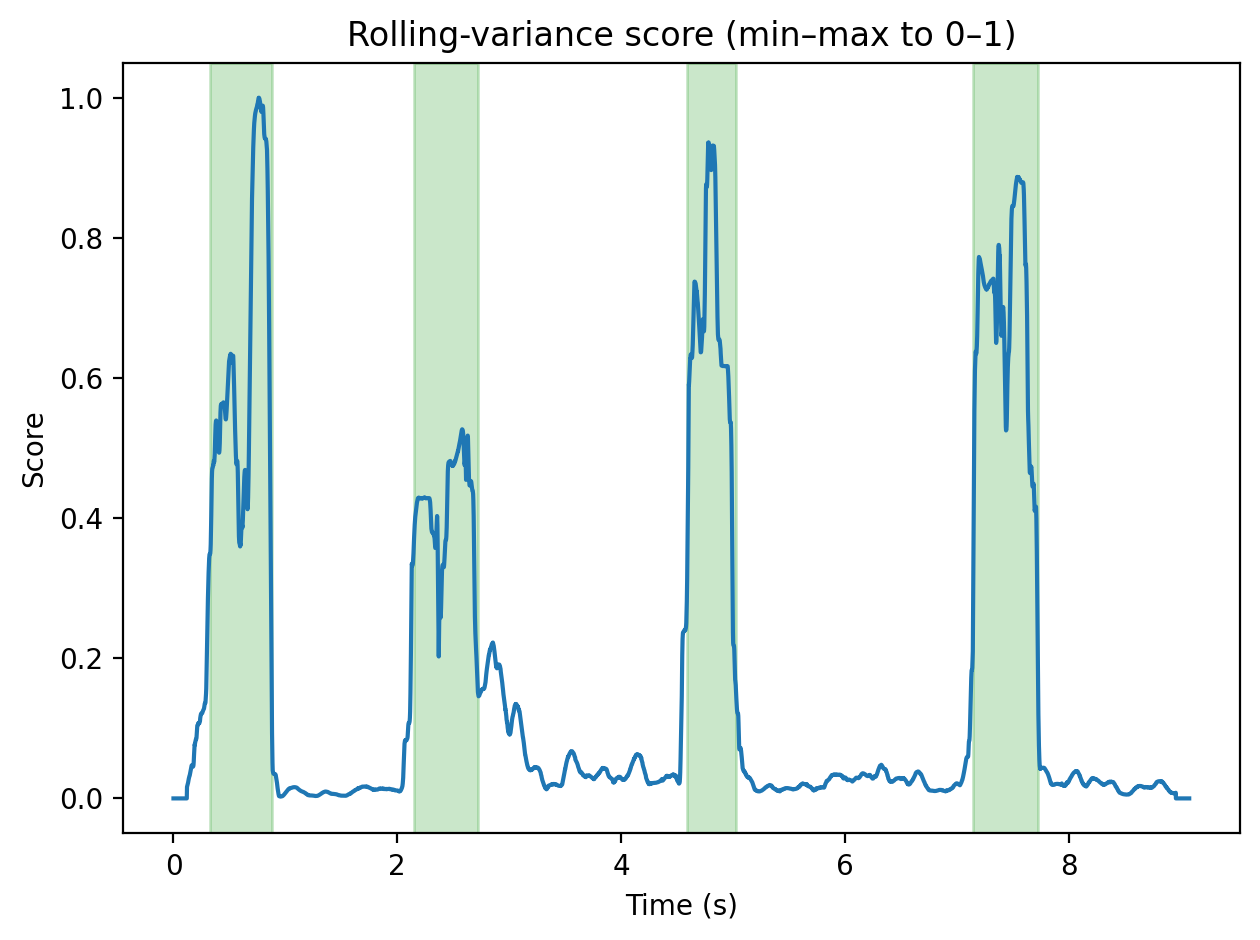

selected: 3 segments: [(1953, 2541), (4450, 4933), (7042, 7501)]


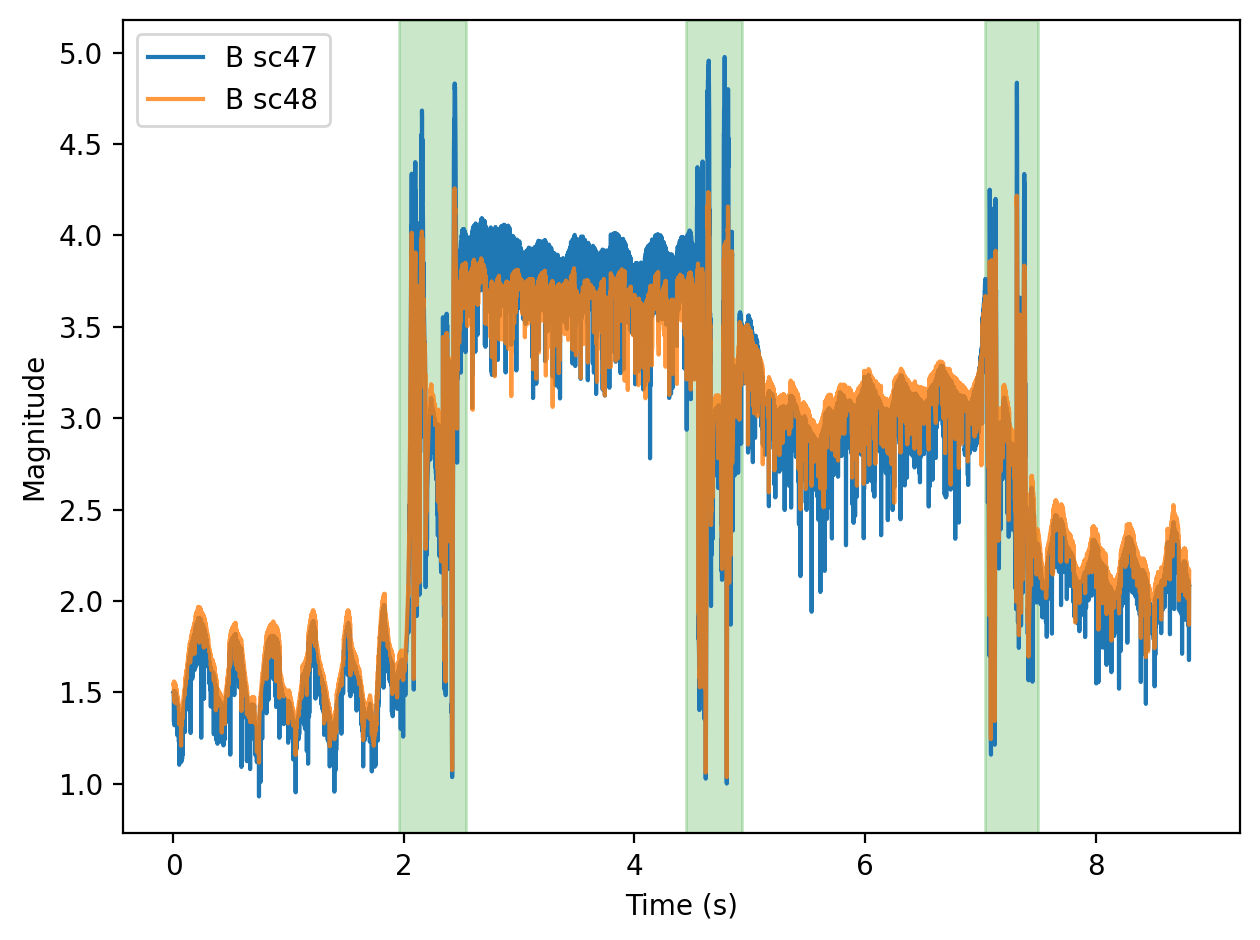

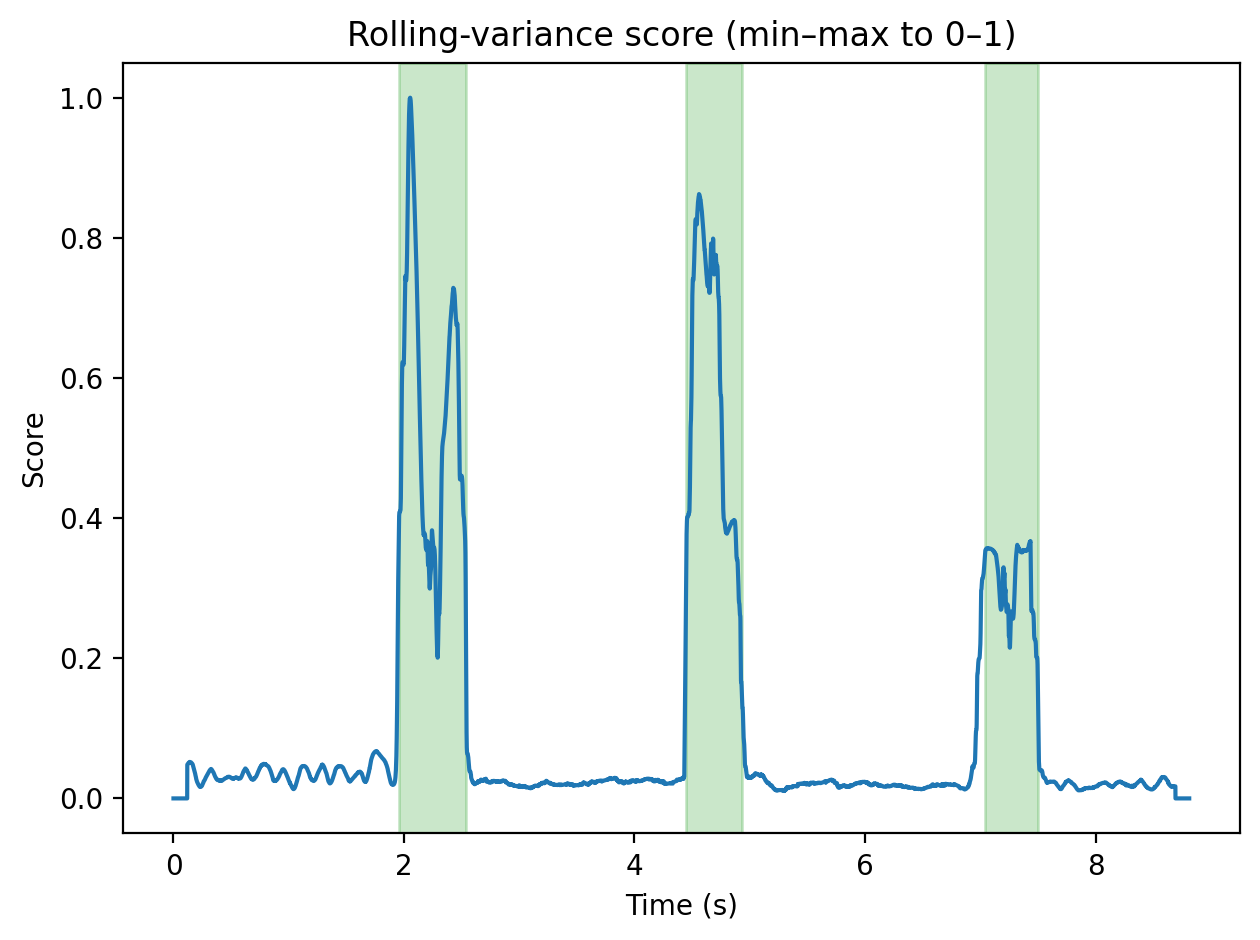

selected: 3 segments: [(4509, 4921), (6953, 7485), (2046, 2537)]


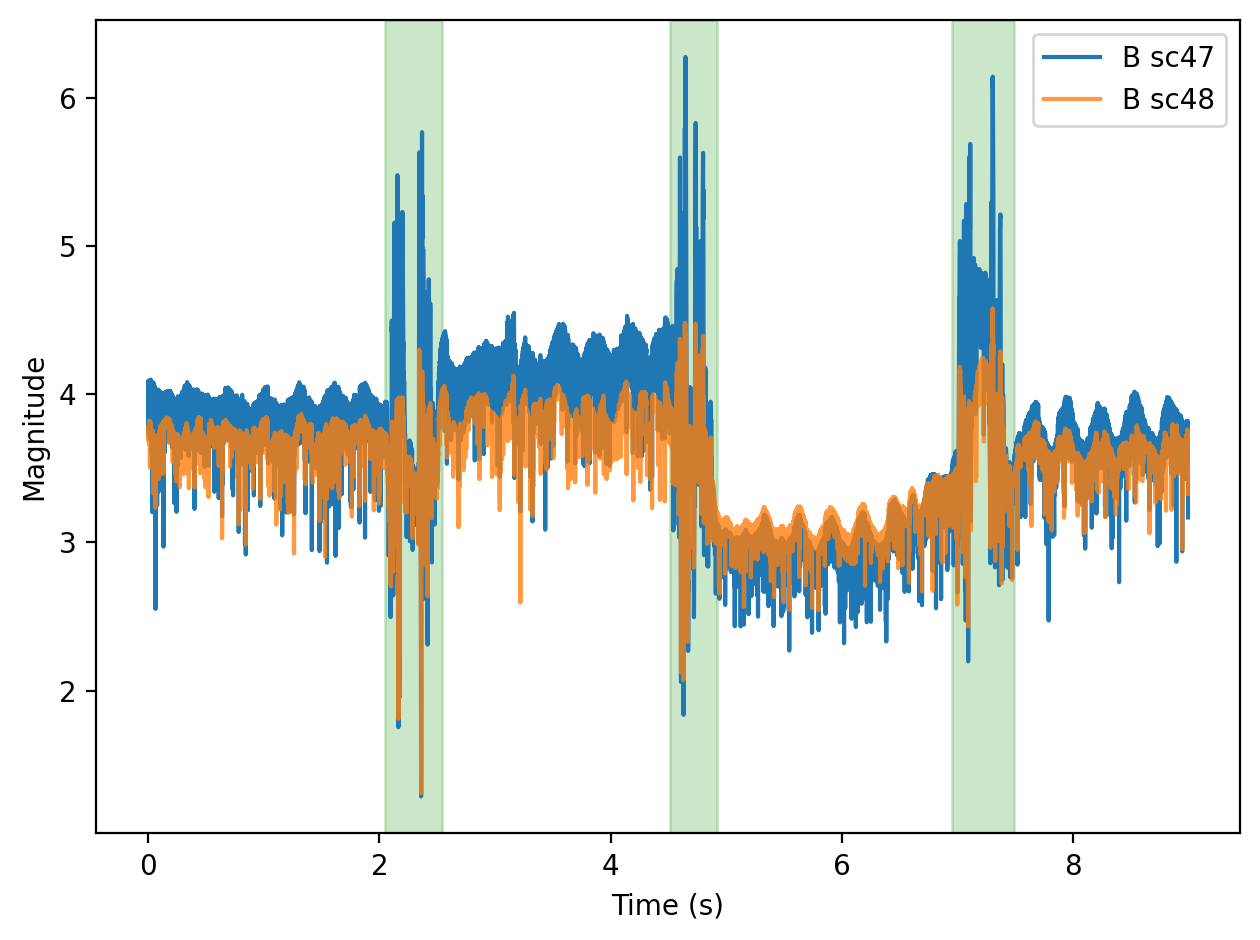

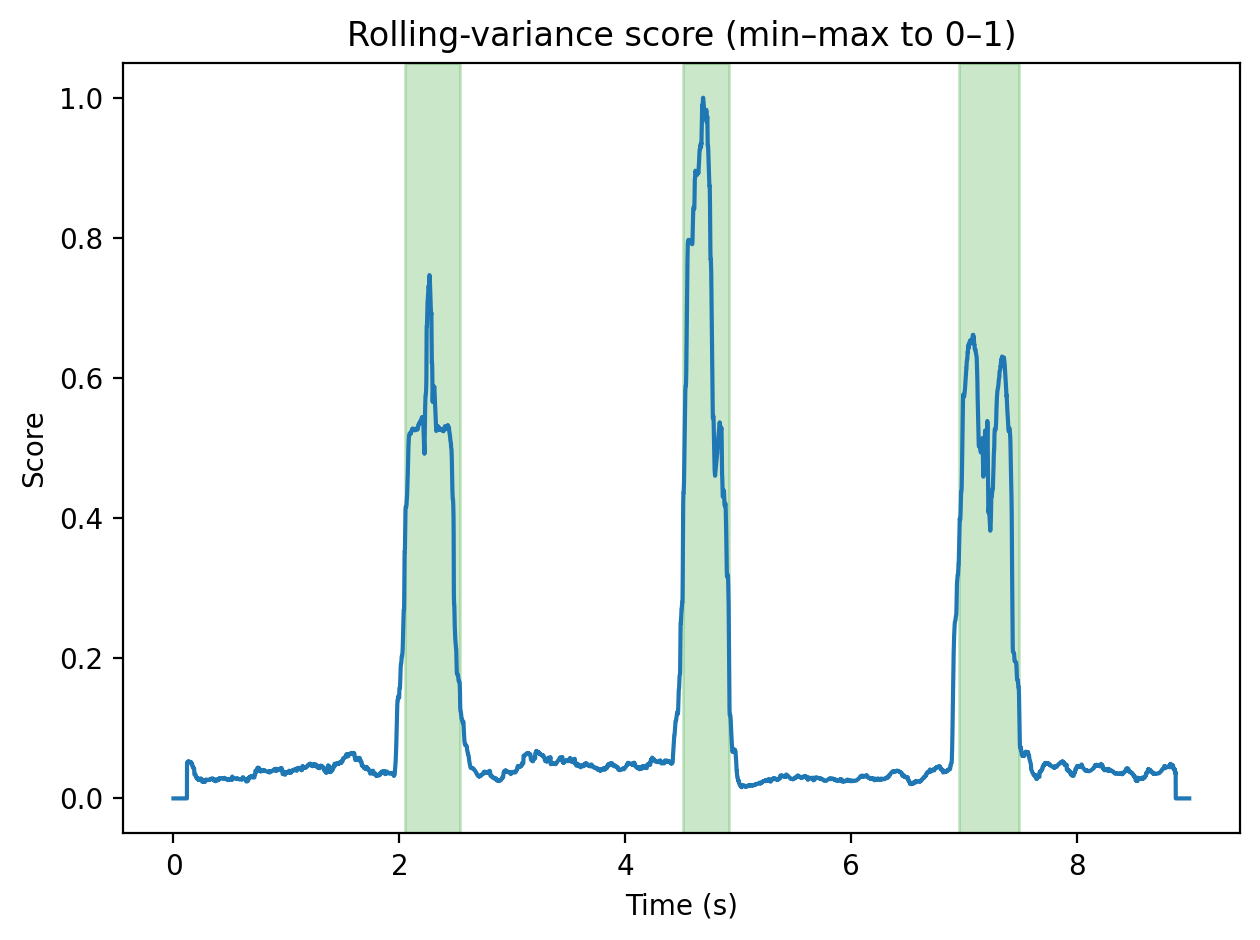

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def minmax01(x, eps=1e-9):
    x = np.asarray(x, float)
    mn, mx = np.nanmin(x), np.nanmax(x)
    return (x - mn) / (mx - mn + eps)

def mask_to_segments(mask):
    m = mask.astype(np.int8)
    dm = np.diff(np.r_[0, m, 0])
    starts = np.where(dm == 1)[0]
    ends   = np.where(dm == -1)[0]
    return list(zip(starts, ends))  # [ (s,e), ... ), e exclusive

# ---------- main: variance-based selector ----------
def select_by_variance(
    df_two_cols: pd.DataFrame,
    fs: float = 1000.0,
    win_ms: int = 50,            # window length for variance (e.g., 30–80 ms)
    combine: str = "mean",       # "mean" or "max" across the two subcarriers
    hi: float = 0.60,            # hysteresis hi threshold on min-max score
    lo: float = 0.30,            # hysteresis lo threshold
    min_dur_ms: int = 150,       # drop segments shorter than this
    min_gap_ms: int = 80,        # merge segments separated by < this gap
    top_k: int = 3,              # keep top-K by energy
):
    # 1) rolling variance per column (centered)
    n = max(1, int(round(win_ms/1000.0 * fs)))
    n = n if n % 2 == 1 else n + 1  # odd window for symmetric centering

    v1 = df_two_cols.iloc[:,0].rolling(window=n, center=True).var(ddof=0).to_numpy()
    v2 = df_two_cols.iloc[:,1].rolling(window=n, center=True).var(ddof=0).to_numpy()
    v1[np.isnan(v1)] = 0.0
    v2[np.isnan(v2)] = 0.0

    # 2) combine channels
    if combine == "max":
        score = np.maximum(v1, v2)
    else:  # "mean"
        score = 0.5*(v1 + v2)

    # 3) normalize score to (0,1)
    s = minmax01(score)

    # 4) hysteresis thresholding
    active = np.zeros_like(s, dtype=bool)
    on = False
    for i, val in enumerate(s):
        if not on and val >= hi: on = True
        elif on and val <= lo:   on = False
        active[i] = on

    # 5) prune short, merge close
    segs = mask_to_segments(active)
    min_dur  = int(round(min_dur_ms/1000.0*fs))
    min_gap  = int(round(min_gap_ms/1000.0*fs))
    segs = [(a,b) for (a,b) in segs if (b-a) >= min_dur]

    merged = []
    for a,b in segs:
        if not merged:
            merged.append([a,b])
        else:
            pa,pb = merged[-1]
            if a - pb <= min_gap:
                merged[-1][1] = max(pb, b)
            else:
                merged.append([a,b])
    segs = [(a,b) for a,b in merged]

    # 6) rank by energy of s and keep top_k
    def energy(seg):
        a,b = seg
        v = s[a:b]
        return float(np.sum(v*v))
    segs_keep = sorted(segs, key=energy, reverse=True)[:top_k]
    indicator = len(segs_keep)

    return segs_keep, indicator, s

# ---------- example usage ----------
# DC is your DataFrame with two magnitude columns (e.g., sc47, sc48); fs=1000 Hz
data_s = DA
segs, count, score = select_by_variance(data_s, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)
print("selected:", count, "segments:", segs)

# quick viz
t = np.arange(len(data_s))/1000.0
plt.figure(dpi=200)
plt.plot(t, data_s.iloc[:,0], label="B sc47")
plt.plot(t, data_s.iloc[:,1], label="B sc48", alpha=0.8)
for (a,b) in segs: plt.axvspan(a/1000.0, b/1000.0, color="tab:green", alpha=0.25)
plt.legend(); plt.xlabel("Time (s)"); plt.ylabel("Magnitude"); plt.tight_layout(); plt.show()

plt.figure(dpi=200)
plt.plot(t, score); 
for (a,b) in segs: plt.axvspan(a/1000.0, b/1000.0, color="tab:green", alpha=0.25)
plt.title("Rolling-variance score (min–max to 0–1)")
plt.xlabel("Time (s)"); plt.ylabel("Score"); plt.tight_layout(); plt.show()


segs, count, score = select_by_variance(DB, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)
print("selected:", count, "segments:", segs)

# quick viz
t = np.arange(len(DB))/1000.0
plt.figure(dpi=200)
plt.plot(t, DB.iloc[:,0], label="B sc47")
plt.plot(t, DB.iloc[:,1], label="B sc48", alpha=0.8)
for (a,b) in segs: plt.axvspan(a/1000.0, b/1000.0, color="tab:green", alpha=0.25)
plt.legend(); plt.xlabel("Time (s)"); plt.ylabel("Magnitude"); plt.tight_layout(); plt.show()

plt.figure(dpi=200)
plt.plot(t, score); 
for (a,b) in segs: plt.axvspan(a/1000.0, b/1000.0, color="tab:green", alpha=0.25)
plt.title("Rolling-variance score (min–max to 0–1)")
plt.xlabel("Time (s)"); plt.ylabel("Score"); plt.tight_layout(); plt.show()


# segs, count, score = select_by_variance(DC, fs=1000.0, win_ms=360, combine="mean",
#                                         hi=0.25, lo=0.10, min_dur_ms=60, min_gap_ms=80, top_k=4)
segs, count, score = select_by_variance(DC, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)
print("selected:", count, "segments:", segs)

# quick viz
t = np.arange(len(DC))/1000.0
plt.figure(dpi=200)
plt.plot(t, DC.iloc[:,0], label="B sc47")
plt.plot(t, DC.iloc[:,1], label="B sc48", alpha=0.8)
for (a,b) in segs: plt.axvspan(a/1000.0, b/1000.0, color="tab:green", alpha=0.25)
plt.legend(); plt.xlabel("Time (s)"); plt.ylabel("Magnitude"); plt.tight_layout(); plt.show()

plt.figure(dpi=200)
plt.plot(t, score); 
for (a,b) in segs: plt.axvspan(a/1000.0, b/1000.0, color="tab:green", alpha=0.25)
plt.title("Rolling-variance score (min–max to 0–1)")
plt.xlabel("Time (s)"); plt.ylabel("Score"); plt.tight_layout(); plt.show()

# selected: 3 segments: [(392, 504), (892, 984), (1404, 1497)]

In [22]:
segs_DA, n_DA, score_DA = select_by_variance(DA, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)

segs_DB, n_DB, score_DB = select_by_variance(DB, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)
segs_DC, n_DC, score_DC = select_by_variance(DC, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)

segs_DA = sorted(segs_DA, key=lambda se: (se[0], se[1]))
segs_DB = sorted(segs_DB, key=lambda se: (se[0], se[1]))
segs_DC = sorted(segs_DC, key=lambda se: (se[0], se[1]))
segs_DA = segs_DA[1: ]

In [23]:
for i in segs_DA:
    print(i[1] - i[0])



577
435
579


In [24]:
for i in segs_DB:
    print(i[1] - i[0])

588
483
459


In [25]:
for i in segs_DC:
    print(i[1] - i[0])

491
412
532


In [27]:
# for i in [DB, DC]:
#     segs, count, score = select_by_variance(i, fs=1000.0, win_ms=40, combine="mean",
#                                         hi=0.3, lo=0.1, min_dur_ms=60, min_gap_ms=80, top_k=4)
    
    # calc the gap of each elements in segs(calc all DB and DC),
    # then select the largest gap(the length )
    # for the rest gap, increase the length(the end index) to force all gaps share the same length
    # then use new variables to store these indexes
    # now since we have the index, and normlized data(DB_norm and DC_norm)
    # apply the DTW to do the simarilty test 


import numpy as np

# --- 1) select segments for DB and DC ---
segs_DA, n_DA, score_DA = select_by_variance(DA, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)
segs_DB, n_DB, score_DB = select_by_variance(DB, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)
segs_DC, n_DC, score_DC = select_by_variance(DC, fs=1000.0, win_ms=240, combine="mean",
                                        hi=0.35, lo=0.15, min_dur_ms=180, min_gap_ms=200, top_k=4)

segs_DA = sorted(segs_DA, key=lambda se: (se[0], se[1]))
segs_DB = sorted(segs_DB, key=lambda se: (se[0], se[1]))
segs_DC = sorted(segs_DC, key=lambda se: (se[0], se[1]))
segs_DA = segs_DA[1: ]
print("DA segments:", segs_DA)
print("DB segments:", segs_DB)
print("DC segments:", segs_DC)

# --- 2) make all segments the same length (use longest), extend end index ---
N_DA = len(DA_norm)
N_DB = len(DB_norm)
N_DC = len(DC_norm)

def extend_to_length(segs, target_len, N):
    """Extend each (s,e) to length=target_len by pushing e right; pad if needed."""
    out = []
    for (s,e) in segs:
        cur_len = e - s
        need = target_len - cur_len
        if need <= 0:
            out.append((s, s + target_len))
            continue
        e2 = min(e + need, N)           # push right
        extra = target_len - (e2 - s)
        if extra > 0:                    # hit boundary—pull start left if possible
            s2 = max(0, s - extra)
            out.append((s2, s2 + target_len))
        else:
            out.append((s, e2))
    return out

# compute the longest segment across both lists
all_lens = [e-s for (s,e) in segs_DA] + [e-s for (s,e) in segs_DB] + [e-s for (s,e) in segs_DC]
if not all_lens:
    raise RuntimeError("No segments found; lower thresholds or min_dur_ms.")
Lmax = max(all_lens)


segs_DA_eq = extend_to_length(segs_DA, Lmax, N_DA)
segs_DB_eq = extend_to_length(segs_DB, Lmax, N_DB)
segs_DC_eq = extend_to_length(segs_DC, Lmax, N_DC)

# 
idx_DA = np.array(segs_DA_eq, dtype=int)   # shape (m, 2)
idx_DB = np.array(segs_DB_eq, dtype=int)   # shape (m, 2)
idx_DC = np.array(segs_DC_eq, dtype=int)   # shape (n, 2)
print("Equalized length:", Lmax, "samples")
print("DA idx:\n", idx_DA)
print("DB idx:\n", idx_DB)
print("DC idx:\n", idx_DC)

# --- 3) build segment tensors from normalized data (2 features = sc36 & sc37 or whichever you used) ---
def segments_from(df_norm, idx):
    segs = []
    X = df_norm.to_numpy(dtype=float)  # (T, 2)
    for s,e in idx:
        seg = X[s:e]                   # (L, 2) ; L == Lmax
        # if rounding caused off-by-one, pad last row
        if seg.shape[0] < Lmax:
            pad = np.repeat(seg[-1:], Lmax - seg.shape[0], axis=0)
            seg = np.vstack([seg, pad])
        segs.append(seg)
    return segs  # list of (Lmax, 2)
DA_segs = segments_from(DA_norm, idx_DA)
DB_segs = segments_from(DB_norm, idx_DB)
DC_segs = segments_from(DC_norm, idx_DC)

def dtw_distance(A, B, normalize=True):
    """
    DTW with Euclidean local cost.
    A: (L1,d), B: (L2,d)
    returns scalar distance; if normalize=True, divide by (L1+L2).
    """
    L1, d = A.shape
    L2, _ = B.shape
    D = np.linalg.norm(A[:, None, :] - B[None, :, :], axis=2)  # (L1,L2)

    acc = np.full((L1+1, L2+1), np.inf)
    acc[0, 0] = 0.0
    for i in range(1, L1+1):
        Di = D[i-1]
        ai = acc[i-1, 1:L2+1]
        bi = acc[i,   0:L2  ]
        ci = acc[i-1, 0:L2  ]
        acc[i, 1:L2+1] = Di + np.minimum(np.minimum(ai, bi), ci)

    dist = float(acc[L1, L2])
    if normalize:
        dist /= (L1 + L2)
    return dist

def pairwise_dtw(segs_X, segs_Y, normalize=True):
    M, N = len(segs_X), len(segs_Y)
    MxN = np.zeros((M, N), dtype=float)
    for i in range(M):
        for j in range(N):
            MxN[i, j] = dtw_distance(segs_X[i], segs_Y[j], normalize=normalize)
    return MxN




DTW_DA_DB = pairwise_dtw(DA_segs, DB_segs, normalize=True)
DTW_DA_DC = pairwise_dtw(DA_segs, DC_segs, normalize=True)
DTW_DB_DC = pairwise_dtw(DB_segs, DC_segs, normalize=True)

print("DTW(DA vs DB):\n", DTW_DA_DB)
print("DTW(DA vs DC):\n", DTW_DA_DC)
print("DTW(DB vs DC):\n", DTW_DB_DC)

# --- 3) quick best-match summary ---
def best_matches(M, left_name, right_name):
    best_j = M.argmin(axis=1)
    best_d = M.min(axis=1)
    for i, (j, d) in enumerate(zip(best_j, best_d)):
        print(f"{left_name} seg {i} ↔ {right_name} seg {j}: DTW={d:.4f}")

best_matches(DTW_DA_DB, "DA", "DB")
best_matches(DTW_DA_DC, "DA", "DC")
best_matches(DTW_DB_DC, "DB", "DC")

DA segments: [(2146, 2723), (4594, 5029), (7149, 7728)]
DB segments: [(1953, 2541), (4450, 4933), (7042, 7501)]
DC segments: [(2046, 2537), (4509, 4921), (6953, 7485)]
Equalized length: 588 samples
DA idx:
 [[2146 2734]
 [4594 5182]
 [7149 7737]]
DB idx:
 [[1953 2541]
 [4450 5038]
 [7042 7630]]
DC idx:
 [[2046 2634]
 [4509 5097]
 [6953 7541]]
DTW(DA vs DB):
 [[0.18765439 0.18980921 0.12837926]
 [0.19847804 0.1834035  0.11933276]
 [0.20526482 0.19242825 0.13050696]]
DTW(DA vs DC):
 [[0.17963128 0.16361835 0.19824925]
 [0.17506571 0.14001297 0.18888178]
 [0.19367244 0.1639363  0.20391432]]
DTW(DB vs DC):
 [[0.14488802 0.17953559 0.16887662]
 [0.11716455 0.15222435 0.15112184]
 [0.15529718 0.12205247 0.16047909]]
DA seg 0 ↔ DB seg 2: DTW=0.1284
DA seg 1 ↔ DB seg 2: DTW=0.1193
DA seg 2 ↔ DB seg 2: DTW=0.1305
DA seg 0 ↔ DC seg 1: DTW=0.1636
DA seg 1 ↔ DC seg 1: DTW=0.1400
DA seg 2 ↔ DC seg 1: DTW=0.1639
DB seg 0 ↔ DC seg 0: DTW=0.1449
DB seg 1 ↔ DC seg 0: DTW=0.1172
DB seg 2 ↔ DC seg 1: DTW

ts shape:  (1816, 53)
shape: (1816, 106)


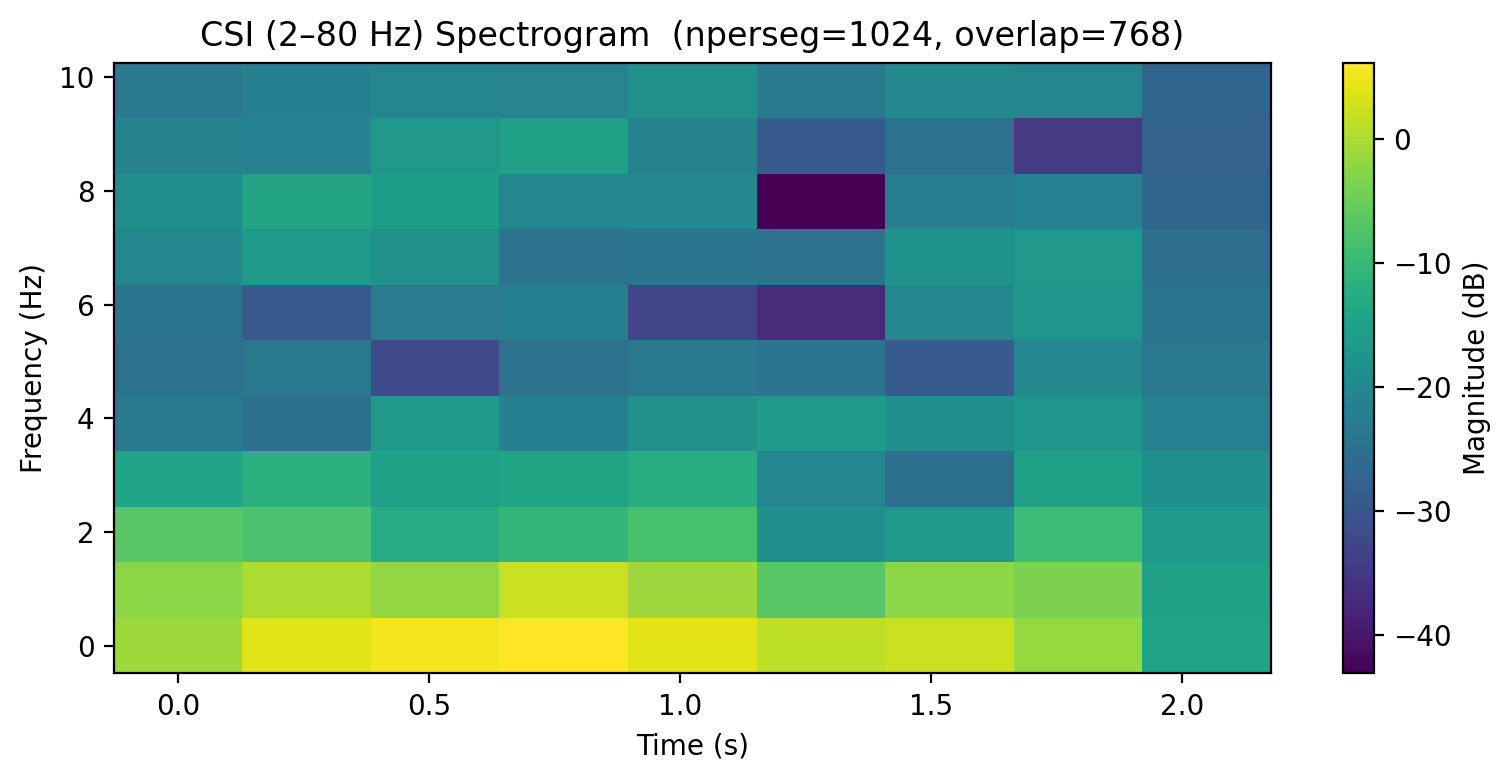

In [136]:
# --- utilities ---
def get_time_axis(H, t):
    """Return the index of the time axis by matching length to t.size."""
    if H.shape[0] == t.size:
        return 0
    elif H.shape[1] == t.size:
        return 1
    else:
        raise ValueError("Couldn't find time axis: H_1k shape vs t.size mismatch.")

def bandpass_zero_phase(x, fs=1000.0, f_lo=2.0, f_hi=80.0, order=4):
    nyq = fs * 0.5
    sos = butter(order, [f_lo/nyq, f_hi/nyq], btype='band', output='sos')
    return sosfiltfilt(sos, x, axis=0)

def take_stream(H, mode="subcarrier", subc_idx=None, use_pca=False, n_pca=1):
    """
    Convert CSI matrix to one 1-D complex stream over time.
    - If mode='subcarrier', pick subcarrier at subc_idx.
    - If use_pca=True, run PCA across subcarriers, return PC1 (or sum first n_pca PCs).
    Expected shapes:
      H: (T, S) or (S, T); we’ll return stream of length T
    """
    # Make it (T, S)
    # if H.shape[0] < H.shape[1]:
    #     print(11111)
    #     # assume (T, S)
    #     H_ts = H
    # else:
    #     # assume (S, T) -> transpose
    #     H_ts = H.T

    T, S = H_ts.shape

    if use_pca:
        # Stack real & imag as features or use magnitude—here we use complex-as-2ch
        X = np.c_[np.real(H_ts), np.imag(H_ts)]  # shape (T, 2S)
        print('shape:', X.shape)
        pca = PCA(n_components=n_pca)
        Z = pca.fit_transform(X)                 # (T, n_pca)
        # Return third one component as a real stream; you can also map it back to complex if desired
        stream = Z[:, 2]
        
        return stream, 1000.0

    # single subcarrier mode
    if subc_idx is None:
        subc_idx = S // 2  # default to center subcarrier
    stream = H_ts[:, subc_idx]
    return stream, 1000.0

def plot_stft(stream, fs=1000.0, nperseg=1024, noverlap=None, fmax=100.0, title="CSI STFT"):
    """
    Plot magnitude spectrogram up to fmax Hz.
    For good low-frequency resolution (2–80 Hz), prefer nperseg≈512–1024 (1.0–0.5 s).
    """
    if noverlap is None:
        noverlap = int(0.75 * nperseg)

    f, tt, Z = stft(stream, fs=fs, window="hann",
                    nperseg=nperseg, noverlap=noverlap, nfft=nperseg, return_onesided=True)
    mag = np.abs(Z)

    # limit frequency to fmax
    keep = f <= fmax
    f2, mag2 = f[keep], mag[keep, :]

    plt.figure(figsize=(8, 4), dpi=200)
    plt.pcolormesh(tt, f2, 20*np.log10(mag2 + 1e-12), shading="auto")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title + f"  (nperseg={nperseg}, overlap={noverlap})")
    cbar = plt.colorbar()
    cbar.set_label("Magnitude (dB)")
    plt.tight_layout()
    plt.show()

# --- how to use on your data ---
# You already have: t, H_1k = resample_csi_to_1khz(...)
time_axis = get_time_axis(H_1k_trim_a, t)

# If H_1k is (S, T), transpose to (T, S) just once for convenience:
H_ts = H_1k_trim_a if time_axis == 0 else H_1k_trim_a.T   # shape (T, S)

# Option A: pick one subcarrier (e.g., center)
# stream_sc, fs = take_stream(H_ts, mode="subcarrier", use_pca=True, n_pca=4)

# Option B (recommended for robustness): PCA across subcarriers -> 1-D stream
print("ts shape: ", H_ts.shape)
stream_sc, fs = take_stream(H_ts, use_pca=True, n_pca=5)

# Optional: bandpass to 2–80 Hz for spoken digits dynamics
# stream_bp = bandpass_zero_phase(stream_sc, fs=fs, f_lo=2.0, f_hi=80.0, order=4)

# Optional feature choices before STFT (pick one):
# 1) magnitude only:
feat = np.abs(stream_sc)
# 2) phase derivative (motion sensitive):
# phase = np.unwrap(np.angle(stream_bp))
# feat = np.gradient(phase) * fs

# Plot STFT
plot_stft(feat, fs=fs, nperseg=1024,fmax=10.0, title="CSI (2–80 Hz) Spectrogram")


In [125]:
import numpy as np
from scipy.signal import butter, sosfiltfilt

def bandpass_csi(H, fs=1000.0, f_lo=5.0, f_hi=80.0, order=4, axis=0):
    """
    Zero-phase bandpass for complex CSI using SOS Butterworth + filtfilt.
    H: array (..., T, ...) where `axis` is the time axis
    """
    nyq = fs * 0.5
    if not (0 < f_lo < f_hi < nyq):
        raise ValueError(f"Cutoffs must satisfy 0 < {f_lo} < {f_hi} < {nyq} Hz")
    sos = butter(order, [f_lo/nyq, f_hi/nyq], btype='band', output='sos')
    return sosfiltfilt(sos, H, axis=axis)

# --- apply to your data ---
# Decide which dimension is time by matching t.size
time_axis = 0 if H_1k_trim.shape[0] == t.size else 1
H_1k_bp = bandpass_csi(H_1k_trim, fs=1000.0, f_lo=0.1, f_hi=100.0, order=4, axis=time_axis)

In [ ]:
# Z shape: (T, n_pca) ; fs in Hz
fs = 1000.0
t = np.arange(H_1k_bp.shape[0]) / fs


import matplotlib.pyplot as plt
plt.figure(dpi=200)    
plt.plot(t, H_1k_trim[:, i], label=f"PC{i+1}")

plt.xlabel("Time (s)")

plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()

plt.show()

In [126]:
np.savetxt(f"csi_butt_{date}_num_0.csv", np.abs(H_1k_bp), delimiter=",")

In [ ]:
 # kHz CSI shape: (1595, 64)  1 kHz CSI shape: (630, 64)

In [ ]:
# drop empty subcarriers

np.abs(H_1k)[0]
# modify H_1k to drop the first 6 subcarriers, and drop the last 5 subcarriers

# H_1k shape: (T, Nsc) complex
T, N = H_1k.shape

keep_idx = np.arange(N)[6:N-5]      # drop first 6, last 5
H_1k_trim = H_1k[1400:2100, keep_idx]       # (T, N-11)

In [ ]:
H_1k_trim = H_1k[400:700, keep_idx]       # (T, N-11)
H_1k_trim.shape
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window

def plot_one_sided_per_subcarrier(H_1k: np.ndarray,
                                  fs: float = 1000.0,
                                  n_carriers: int = 10,
                                  method: str = "welch",   # "welch" | "fft"
                                  welch_nperseg: int = 512,
                                  welch_noverlap: int = 384,
                                  nfft: int | None = None, # for method="fft"
                                  assume_real: bool = False,  # set True only if your time series are real
                                  eps: float = 0.0):
    """
    Plot 0..fs/2 spectrum for the first n_carriers.
    H_1k: complex array (T, Nsc) — CSI at rate fs
    """
    H_1k = np.asarray(H_1k)
    T, Nsc = H_1k.shape
    nonempty = [k for k in range(Nsc) if np.max(np.abs(H_1k[:, k])) > eps]
    sel = nonempty[:min(n_carriers, len(nonempty))]

    for k in sel:
        x = H_1k[:, k]

        if method.lower() == "welch":
            # two-sided first (works for complex), then keep f>=0
            nper = min(welch_nperseg, T)
            nover = min(welch_noverlap, max(0, nper-1))
            f, Pxx = welch(x, fs=fs, window="hann", nperseg=nper, noverlap=nover,
                           detrend="constant", return_onesided=False, scaling="density")
            pos = f >= 0
            f = f[pos]; Pxx = Pxx[pos]
            if assume_real and len(Pxx) > 2:
                Pxx[1:-1] *= 2.0  # double power for positive freqs (except DC/Nyquist) for real signals
            PdB = 10*np.log10(Pxx + 1e-18)

            plt.figure()
            plt.plot(f, PdB)
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("PSD (dB/Hz)")
            plt.title(f"Subcarrier {k} — One-sided Welch PSD")
            plt.tight_layout()
            plt.show()

        elif method.lower() == "fft":
            # window, FFT, then keep f>=0
            if nfft is None:
                nfft = int(2**np.ceil(np.log2(T)))  # next pow2
            w = get_window("hann", T)
            X = np.fft.fft((x - np.mean(x)) * w, n=nfft)
            f = np.fft.fftfreq(nfft, d=1.0/fs)
            pos = f >= 0
            f = f[pos]; X = X[pos]
            # Power spectrum (not PSD)
            P = (np.abs(X)**2) / (np.sum(w**2))  # simple periodogram scaling
            if assume_real and len(P) > 2:
                P[1:-1] *= 2.0
            PdB = 10*np.log10(P + 1e-18)

            plt.figure()
            plt.plot(f, PdB)
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Power (dB)")
            plt.title(f"Subcarrier {k} — One-sided FFT")
            plt.tight_layout()
            plt.show()

        else:
            raise ValueError("method must be 'welch' or 'fft'")

# ---- Example ----
# H_1k = np.load("csi_1khz_<date>_num_0.npy")   # shape (T, 64), complex64
# plot_one_sided_per_subcarrier(H_1k, fs=1000.0, n_carriers=10, method="welch")
# plot_one_sided_per_subcarrier(H_1k, fs=1000.0, n_carriers=10, method="fft", nfft=4096)


# -------- Example usage --------
# H_1k = np.load("csi_1khz_<date>_num_0.npy")  # shape (T, 64), complex64
# plot_fft_per_subcarrier(H_1k, fs=1000.0, n_carriers=10, method="welch")
plot_one_sided_per_subcarrier(H_1k_trim, fs=1000.0, n_carriers=53, method="fft", nfft=4096)


In [15]:

# without averaging process
path = "taps_9_5_B_num_0.txt"   # your captured file
syms = read_symbol_csi(path)   # list of 64-bin complex vectors, one per OFDM symbol
# If you have DC/guards, you can exclude them from CPE/normalization:
used_mask = None
assert len(syms) > 0 and all(len(s) == len(syms[0]) for s in syms), "Symbols must be equal length"
syms_arr = np.stack(syms, axis=0).astype(np.complex64)   # [Nsym, Nsub

In [ ]:
print("CSI shape: ", syms_arr.shape)
# H_1k is your (T, 64) complex CSI at 1 kHz
H_smooth = smooth_H1k(syms_arr, fs=1000.0, method='moving', cutoff=15.0, order=3)
# If you only need smoothed magnitudes for plots:
mag_sm = np.abs(H_smooth)  # shape (T, 64)
np.savetxt(f"csi_original_mag_smoothed_{date}_num_0.csv", np.abs(H_smooth), delimiter=",")

CSI shape:  (79662, 64)


In [ ]:

## smooth first then resample
t, H_1k = resample_csi_to_1khz(
    H_smooth,
    fs=5e6, nfft=64, cp_ratio=1/4,
    do_cpe=True,
    used_bins=used_mask,
    amp_norm=None,     # or 'rms' for scale invariance
    fill="zoh"
)
print("1 kHz CSI shape:", H_1k.shape)   # (N_out, 64)

np.savetxt(f"csi_1khz_smoothed_resample_{date}_num_0.csv", np.abs(H_1k), delimiter=",")

In [4]:
date = '9_5_B'

# without averaging process
path = "taps_9_5_B_num_0.txt"   # your captured file
syms = read_symbol_csi(path)   # list of 64-bin complex vectors, one per OFDM symbol
# If you have DC/guards, you can exclude them from CPE/normalization:
used_mask = None
assert len(syms) > 0 and all(len(s) == len(syms[0]) for s in syms), "Symbols must be equal length"
syms_arr = np.stack(syms, axis=0).astype(np.complex64)   # [Nsym, Nsub

aaa = np.abs(syms_arr)
np.savetxt(f"csi_original_mag_{date}_num_0.csv", np.abs(syms_arr), delimiter=",")

In [12]:
import re
from typing import List, Tuple, Optional
import numpy as np

# ---- 1) Parse the file: each "Taps starting:" section -> one packet (64 complex bins) ----
_PAIR = re.compile(
    r"\(\s*([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*,\s*"
    r"([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*\)"
)

def read_csi_packets(
    path: str,
    section_headers=("Taps starting", "CSI starting"),
) -> List[np.ndarray]:
    """Return list of complex64 arrays, one per packet, length should be 64."""
    packets: List[np.ndarray] = []
    cur: List[Tuple[float, float]] = []

    def flush():
        nonlocal cur
        if cur:
            arr = np.array([a + 1j*b for a, b in cur], dtype=np.complex64)
            packets.append(arr)
            cur = []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            low = s.lower()
            if any(h.lower() in low for h in section_headers):
                flush()
                continue
            m = _PAIR.search(s)
            if m:
                a = float(m.group(1)); b = float(m.group(2))
                cur.append((a, b))
    flush()
    return packets

# ---- 2) Detect the fixed non-empty subcarrier indices ----
def find_nonempty_mask(packets: List[np.ndarray], eps: float = 0.0) -> np.ndarray:
    """
    Returns a boolean mask where True = non-empty subcarrier.
    Assumes empty indices are identical for all packets.
    'Empty' means |H| <= eps (eps=0.0 => exactly (0,0)).
    """
    if not packets:
        raise ValueError("No packets found.")
    N = len(packets[0])
    if any(len(p) != N for p in packets):
        raise ValueError("Inconsistent packet lengths.")
    # Mask from first packet
    mask0 = np.abs(packets[0]) > eps
    # Verify consistency
    # for i, p in enumerate(packets[1:], start=1):
    #     mask_i = np.abs(p) > eps
    #     if not np.array_equal(mask0, mask_i):
    #         # If this ever happens, you can choose an intersection or raise.
    #         raise ValueError(f"Non-empty mask differs at packet {i}. "
    #                          "Your assumption 'empty index is the same for each packet' is violated.")
    return mask0

# ---- 3) Convert to sparse triplets: (packet_id, subcarrier_index, real, imag) ----
def packets_to_triplets(
    packets: List[np.ndarray],
    mask: np.ndarray
) -> np.ndarray:
    """
    Returns a structured array of shape (num_packets * num_nonempty,) with fields:
      ('packet', i4), ('index', i4), ('real', f4), ('imag', f4)
    """
    idxs = np.nonzero(mask)[0]
    M = len(packets); K = len(idxs)
    out = np.empty(M * K, dtype=[('packet', 'i4'), ('index', 'i4'),
                                 ('real', 'f4'), ('imag', 'f4')])
    pos = 0
    for p_id, H in enumerate(packets):
        vals = H[idxs]
        n = K
        out['packet'][pos:pos+n] = p_id
        out['index'][pos:pos+n]  = idxs.astype(np.int32)
        out['real'][pos:pos+n]   = vals.real.astype(np.float32)
        out['imag'][pos:pos+n]   = vals.imag.astype(np.float32)
        pos += n
    return out

# ---- 4) Convenience wrapper (with optional saving) ----
def csi_sparse_triplets(
    path: str,
    eps: float = 0.0,
    save_csv: Optional[str] = None,
    save_npy: Optional[str] = None,
):
    packets = read_csi_packets(path)
    mask = find_nonempty_mask(packets, eps=eps)    # fixed non-empty bins
    trips = packets_to_triplets(packets, mask)

    if save_npy:
        np.save(save_npy, trips)
    if save_csv:
        # Write as CSV with header
        header = "packet,index,real,imag"
        data = np.column_stack([trips['packet'], trips['index'], trips['real'], trips['imag']])
        np.savetxt(save_csv, data, delimiter=",", header=header, comments="", fmt=["%d","%d","%.7g","%.7g"])

    # Also return the compact form if you want it later:
    idxs = np.nonzero(mask)[0]
    values_matrix = np.stack([p[idxs] for p in packets], axis=0)  # shape (num_packets, num_nonempty), complex64
    return {
        "triplets": trips,                 # (P*K,) structured array of (packet, index, real, imag)
        "nonempty_indices": idxs,          # (K,) int array of kept subcarriers
        "values_matrix": values_matrix,    # (P, K) complex64 matrix
    }


path = "taps_9_17_num_0.txt"   # your CSI file
result = csi_sparse_triplets(path, eps=0.0, save_csv="csi_sparse_triplets.csv", save_npy="csi_sparse_triplets.npy")
trips = result["triplets"]
idxs = result["nonempty_indices"]
vals = result["values_matrix"]

print(f"Packets: {vals.shape[0]}, Non-empty bins: {vals.shape[1]}")
print("First few triplets:\n", trips[: min(10, len(trips))])
print("Non-empty indices:", idxs)


## then go through the triplets data, read the first ten carriers data(read all value), 
# then plot stft for each carriers in ten seperate figure, also i dont know how to real with the complex data,
# you need to consider that

Packets: 213970, Non-empty bins: 52
First few triplets:
 [(0,  6,  0.309607 , -0.115972 ) (0,  7,  0.0931045, -0.247237 )
 (0,  8, -0.200882 , -0.237309 ) (0,  9, -0.27424  ,  0.034945 )
 (0, 10,  0.176745 ,  0.34341  ) (0, 11, -0.41248  ,  0.186053 )
 (0, 12,  0.211973 ,  0.302028 ) (0, 13,  0.279804 , -0.0306019)
 (0, 14,  0.254571 , -0.145994 ) (0, 15, -0.226359 , -0.0847008)]
Non-empty indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

def triplets_to_matrix(triplets: np.ndarray):
    """
    triplets: structured array with fields ('packet','index','real','imag')
    Returns:
      packets_sorted: 1D int array of packet ids in ascending order
      indices_sorted: 1D int array of carrier indices in ascending order
      values: complex ndarray of shape [num_packets, num_carriers]
    """
    # Basic field checks
    for fld in ('packet', 'index', 'real', 'imag'):
        if fld not in triplets.dtype.names:
            raise ValueError(f"triplets missing field '{fld}'")

    packets_sorted = np.unique(triplets['packet'])
    indices_sorted = np.unique(triplets['index'])
    P, K = len(packets_sorted), len(indices_sorted)

    # Map packet/index -> row/col
    p_map = {p:i for i,p in enumerate(packets_sorted)}
    k_map = {k:i for i,k in enumerate(indices_sorted)}

    values = np.zeros((P, K), dtype=np.complex64)
    # Fill matrix
    for r in triplets:
        pr = p_map[int(r['packet'])]
        kc = k_map[int(r['index'])]
        values[pr, kc] = r['real'] + 1j*r['imag']

    return packets_sorted, indices_sorted, values

def plot_first_n_carrier_stfts(triplets: np.ndarray,
                               n_carriers: int = 10,
                               fs: float = 1000.0,
                               nperseg: int = 256,
                               noverlap: int = 192):
    """
    Plots STFT power spectrograms of the first n_carriers (by carrier index order).
    - fs: CSI sampling rate in Hz (set to your 1 kHz stream rate; if you're at packet rate R, set fs=R)
    - nperseg/noverlap: STFT parameters
    """
    pkts, idxs, vals = triplets_to_matrix(triplets)  # vals: [num_packets, num_carriers]

    # Safety: adapt STFT window if the sequence is short
    T = vals.shape[0]
    if T <= nperseg:
        nperseg = max(16, T // 2)
        noverlap = max(0, nperseg // 2)

    n = min(n_carriers, vals.shape[1])

    for j in range(n):
        series = vals[:, j]  # complex time series for carrier j across packets/time

        # Complex STFT; we'll plot power |Z|^2
        f, t, Z = stft(series, fs=fs, nperseg=nperseg, noverlap=noverlap,
                       return_onesided=False, boundary=None)
        S = np.abs(Z) ** 2
        # Center zero frequency
        S_shift = np.fft.fftshift(S, axes=0)
        f_shift = np.fft.fftshift(f)
        S_db = 10.0 * np.log10(S_shift + 1e-12)

        plt.figure()
        plt.imshow(
            S_db,
            origin='lower',
            aspect='auto',
            extent=[t[0], t[-1], f_shift[0], f_shift[-1]]
        )
        plt.xlabel('Time (s)')
        plt.ylabel('Doppler (Hz)')
        plt.title(f'Carrier index {int(idxs[j])} — STFT Power')
        cbar = plt.colorbar()
        cbar.set_label('Power (dB)')
        plt.tight_layout()
        plt.show()

# Load the structured triplets saved earlier (from csi_sparse_triplets)
trips = np.load("csi_sparse_triplets.npy", allow_pickle=False)
# If your CSI stream is exactly 1 kHz, fs=1000. If it's per-packet at R packets/s, set fs=R.
plot_first_n_carrier_stfts(trips, n_carriers=40, fs=1000.0, nperseg=256, noverlap=192)


In [ ]:
path = "taps_8_31_num_1.txt"   # your captured file
syms = read_symbol_csi(path)   # list of 64-bin complex vectors, one per OFDM symbol

In [57]:
syms

[array([ 0.00000e+00+0.j        ,  0.00000e+00+0.j        ,
         0.00000e+00+0.j        ,  0.00000e+00+0.j        ,
         0.00000e+00+0.j        ,  0.00000e+00+0.j        ,
         1.15793e-01-0.0114993j , -7.41923e-02-0.0617091j ,
        -6.49559e-02-0.100361j  , -1.07236e-01-0.0248731j ,
         1.29925e-02+0.148004j  , -1.49308e-01-0.00737587j,
         8.92938e-03+0.136285j  ,  9.20660e-02+0.0572721j ,
         1.53255e-02-0.105332j  ,  8.34263e-02-0.0471871j ,
         6.34599e-02-0.129034j  ,  9.59908e-02-0.0810274j ,
        -1.23411e-01-0.0578988j , -8.36687e-02-0.120922j  ,
        -1.21874e-01-0.0377087j , -9.85315e-02+0.066378j  ,
         1.04255e-01+0.0329109j ,  1.27372e-01+0.0180369j ,
         3.42290e-02-0.122134j  ,  1.38125e-01-0.045822j  ,
        -7.36276e-02-0.108328j  , -2.25526e-02-0.0886801j ,
        -1.61463e-01+0.0889546j , -5.32789e-03+0.118354j  ,
         3.80768e-02+0.0873145j ,  1.04261e-01+0.0110042j ,
         0.00000e+00+0.j        ,  6.110

In [ ]:

print(f"Loaded {len(syms)} symbols; Nsub={len(syms[0])}")
# If you have DC/guards, you can exclude them from CPE/normalization:
used_mask = None

date = '8_31'

# used_mask = np.ones(64, dtype=bool); used_mask[32] = False  # example: drop DC bin

t, H_1k = resample_csi_to_1khz(
    syms,
    fs=5e6, nfft=64, cp_ratio=1/4,
    do_cpe=True,
    used_ssssssbins=used_mask,
    amp_norm=None,     # or 'rms' for scale invariance
    fill="zoh"
)

Loaded 94734 symbols; Nsub=64


In [ ]:
H_1k[0].shape

(64,)

In [51]:
print("1 kHz CSI shape:", H_1k.shape)   # (N_out, 64)
np.save(f"csi_1khz_{date}_num_1.npy", H_1k)           # complex64 time series
# Optional exports for ML:
np.savetxt(f"csi_1khz_mag_{date}_num_1.csv", np.abs(H_1k), delimiter=",")
np.savetxt(f"csi_1khz_phase_{date}_num_1.csv", np.angle(H_1k), delimiter=",")

1 kHz CSI shape: (1516, 64)


In [52]:
H_1k

array([[0.01587101+0.0002526j , 0.01587101+0.0002526j ,
        0.01587101+0.0002526j , ..., 0.01587101+0.0002526j ,
        0.01587101+0.0002526j , 0.01587101+0.0002526j ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.01584928+0.00086772j, 0.01584928+0.00086772j,
        0.01584928+0.00086772j, ..., 0.01584928+0.00086772j,
        0.01584928+0.00086772j, 0.01584928+0.00086772j],
       ...,
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.03171724+0.00094308j, 0.03171724+0.00094308j,
        0.03171724+0.00094308j, ..., 0.03171724+0.00094308j,
        0.03171724+0.00094308j, 0.03171724+0.00094308j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , ..., 0.        +0.j        ,
 

## Doppler spectrogram

In [6]:
import numpy as np
from scipy.signal import butter, filtfilt, stft, detrend

def bandpass(x, fs, lo=0.2, hi=20.0, order=4):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)

def remove_static(H, win_sec=2.0, fs=1000):
    # running mean (causal-ish EMA) to remove static part
    alpha = 1 - np.exp(-1.0/(win_sec*fs))
    m = np.zeros_like(H, dtype=np.complex64)
    out = np.empty_like(H)
    for t in range(H.shape[0]):
        m[t] = (1-alpha)*m[t-1] + alpha*H[t] if t>0 else H[0]
        out[t] = H[t] - m[t]
    return out

def phase_rate(H, fs):
    # unwrap over time per subcarrier, finite-difference
    ph = np.unwrap(np.angle(H), axis=0)
    dph = np.diff(ph, axis=0) * fs / (2*np.pi)   # Hz
    # pad to original length
    dph = np.pad(dph, ((1,0),(0,0)), mode='edge')
    return dph

def doppler_spectrogram(H_dyn, fs=1000, nperseg=256, noverlap=192):
    # Use complex dynamic CSI; average spectrogram across subcarriers
    f, t, Z = stft(H_dyn, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=0, return_onesided=False)
    S = np.mean(np.abs(Z)**2, axis=2)  # [freq, time]
    return f, t, S

def delay_taps(H, pad=4):
    # IFFT across subcarriers per time → taps (zero-padded for finer grid)
    T, N = H.shape
    Hf = np.fft.ifftshift(H, axes=1)            # if your DC is at center; skip if already shifted
    Hp = np.pad(Hf, ((0,0),(0,(pad-1)*N)), mode='constant')
    taps = np.fft.ifft(Hp, axis=1)
    P = np.abs(taps)**2
    return P[:, :N//2]  # keep first half (causal-ish paths)

# ----- end-to-end example -----
def extract_common_features(H_1k):
    fs = 1000
    # 1) remove static + band-pass (per subcarrier)
    H_dyn = remove_static(H_1k)
    H_dyn = bandpass(H_dyn.view(np.float64).reshape(H_dyn.shape[0], -1), fs) \
              .reshape(H_dyn.shape).view(np.complex128)  # bandpass real+imag together
    H_dyn = H_dyn.astype(np.complex64)

    # 2) micro-Doppler spectrogram
    f, t, S = doppler_spectrogram(H_dyn, fs=fs, nperseg=256, noverlap=192)  # S: [F,T]

    # 3) delay-time energy (first ~10–15 taps typically useful)
    Pdelay = delay_taps(H_dyn)  # shape [T, K]

    # 4) simple stats over short windows can be added here if you prefer classical features

    return dict(doppler_freq=f, doppler_time=t, doppler_S=S,
                delay_energy=Pdelay)




In [44]:
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt

def extract_common_features(H_1k, plot_random=True, rng_seed=None):
    """
    H_1k: array (T, 64) complex — 1 kHz CSI snapshots
    Returns dict with doppler spectrogram (avg across subcarriers) and delay energy.
    If plot_random=True, also plots the spectrogram of one randomly chosen subcarrier.
    """
    fs = 1000

    # 1) remove static + band-pass (per subcarrier)
    H_dyn = remove_static(H_1k)
    H_dyn = bandpass(H_dyn.view(np.float64).reshape(H_dyn.shape[0], -1), fs) \
              .reshape(H_dyn.shape).view(np.complex128)
    H_dyn = H_dyn.astype(np.complex64)

    # 2) micro-Doppler spectrogram (average across subcarriers)
    f, t, Z = stft(H_dyn, fs=fs, nperseg=256, noverlap=192, axis=0, return_onesided=False)
    S = np.mean(np.abs(Z)**2, axis=2)  # [freq, time]

    # 3) delay-time energy (first ~10–15 taps typically useful)
    Pdelay = delay_taps(H_dyn)  # shape [T, K]

    # Center zero-Doppler and convert to dB
    S_shift = np.fft.fftshift(S, axes=0)
    f_shift = np.fft.fftshift(f)
    S_db = 10.0 * np.log10(S_shift + 1e-12)

    plt.figure()
    plt.imshow(
        S_db,
        origin='lower',
        aspect='auto',
        extent=[t[0], t[-1], f_shift[0], f_shift[-1]]
    )
    plt.xlabel('Time (s)')
    plt.ylabel('Doppler (Hz)')
    plt.title('Micro-Doppler (avg across subcarriers)')
    cbar = plt.colorbar()
    cbar.set_label('Power (dB)')
    plt.tight_layout()
    plt.show()

    return dict(doppler_freq=f, doppler_time=t, doppler_S=S, delay_energy=Pdelay)


In [46]:
H_1k

array([[0.01587302+0.0000000e+00j, 0.01587302+0.0000000e+00j,
        0.01587302+0.0000000e+00j, ..., 0.01587302+0.0000000e+00j,
        0.01587302+0.0000000e+00j, 0.01587302+0.0000000e+00j],
       [0.04838689+9.6073985e-05j, 0.04838689+9.6073985e-05j,
        0.04838689+9.6073985e-05j, ..., 0.04838689+9.6073985e-05j,
        0.04838689+9.6073985e-05j, 0.04838689+9.6073985e-05j],
       [0.04761902-3.2124022e-05j, 0.04761902-3.2124022e-05j,
        0.04761902-3.2124022e-05j, ..., 0.04761902-3.2124022e-05j,
        0.04761902-3.2124022e-05j, 0.04761902-3.2124022e-05j],
       ...,
       [0.03174596-1.1826927e-05j, 0.03174596-1.1826927e-05j,
        0.03174596-1.1826927e-05j, ..., 0.03174596-1.1826927e-05j,
        0.03174596-1.1826927e-05j, 0.03174596-1.1826927e-05j],
       [0.04761801+1.7513789e-04j, 0.04761801+1.7513789e-04j,
        0.04761801+1.7513789e-04j, ..., 0.04761801+1.7513789e-04j,
        0.04761801+1.7513789e-04j, 0.04761801+1.7513789e-04j],
       [0.        +0.0000000

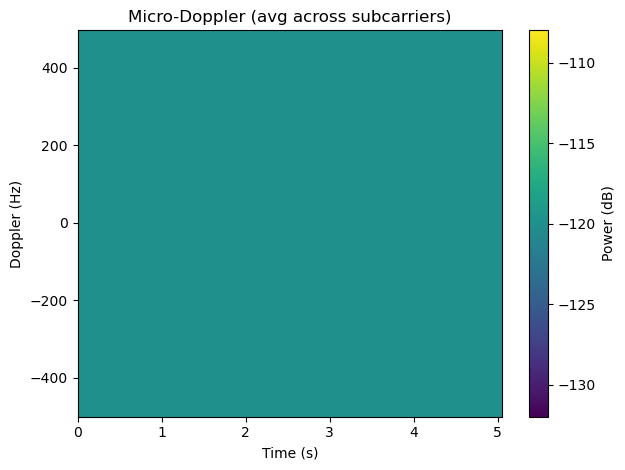

In [45]:
# Usage:
H_1k = np.load("csi_1khz.npy")   # shape (T, 64), complex64
feats = extract_common_features(H_1k)
# np.save("doppler_S.npy", feats["doppler_S"])
# np.save("delay_energy.npy", feats["delay_energy"])